In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import re

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def check_metrics(true_val, pred_val):
    print("Accuracy: ", accuracy_score(true_val, pred_val))
    print("Roc_Auc: ", roc_auc_score(true_val, pred_val))
    print("Precision: ", precision_score(true_val, pred_val), " - процент правильно токсичных")
    print("Recall: ", recall_score(true_val, pred_val), " - процент выбранных токсичных")

data = pd.read_csv("toxic_train.csv")

test_data = pd.read_csv("toxic_test.csv")


train_texts = np.array(data['comment_text'])
for enum in range(train_texts.__len__()):
    train_texts[enum] = train_texts[enum].lower()
    train_texts[enum] = re.sub("[^0-9a-zA-Z']+", ' ', train_texts[enum])
    train_texts[enum] =  re.sub(' +', ' ', train_texts[enum])


    
test_texts = np.array(test_data['comment_text'])
for enum in range(test_texts.__len__()):
    test_texts[enum] = test_texts[enum].lower()
    test_texts[enum] = re.sub("[^0-9a-zA-Z']+", ' ', test_texts[enum])
    test_texts[enum] =  re.sub(' +', ' ', test_texts[enum])


train_target = np.array(data['is_toxic']).astype(int) * 2 - 1 
test_target = np.array(test_data['is_toxic']).astype(int) * 2 - 1

In [151]:
import scipy
def add_1(X):
    sub = scipy.sparse.csr_matrix(np.ones(X.shape[0])[:, None])
    
    return scipy.sparse.csr_matrix(scipy.sparse.hstack((X, sub)))

In [4]:
from optimization import GDClassifier

In [4]:
train_texts[0]

"explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalisms just closure on some gas after i voted at new york dolls fac and please don't remove the template from the talk page since i'm retired now 89 205 38 27"

Попробуем применить spacy алгоритм лемматизации

In [5]:
import spacy

spacy.util.set_data_path("/usr/local/lib/python3.7/site-packages/spacy/data")

In [6]:
nlp = spacy.load("en", disable = ["parser", "ner"])

В качестве примера возьмем первый элемент тренировочной выборки:

In [7]:
data['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

Пример работы на не модифицированных входных данных

In [8]:
doc = nlp(data['comment_text'][0])

" ".join([token.lemma_ for token in doc])

'explanation \n why the edit make under -PRON- username Hardcore Metallica Fan be revert ? -PRON- be not vandalism , just closure on some gas after -PRON- vote at New York Dolls FAC . and please do not remove the template from the talk page since -PRON- be retire now.89.205.38.27'

На модифицированных входных данных:

In [9]:
doc = nlp(train_texts[0])

" ".join([token.lemma_ for token in doc])

'explanation why the edit make under -PRON- username hardcore metallica fan be revert -PRON- be not vandalism just closure on some gas after i vote at new york doll fac and please do not remove the template from the talk page since -PRON- be retire now 89 205 38 27'

Применим ко всей выборке:

In [10]:
result = []

for item in train_texts:
    
    doc = nlp(item)
    
    result.append(" ".join([token.lemma_ for token in doc]))

In [11]:
test_result = []

for item in test_texts:
    
    doc = nlp(item)
    
    test_result.append(" ".join([token.lemma_ for token in doc]))

Посмотим, что это нам дало:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
vect = CountVectorizer(min_df = 20)

In [14]:
train_matrix = vect.fit_transform(result)

In [15]:
train_matrix.shape

(52061, 5884)

In [16]:
test_matrix = vect.transform(test_result)

In [17]:
classifier = GDClassifier(step_alpha = 2.6, step_beta = 0, l2_coef = 0)

In [18]:
classifier.fit(train_matrix, train_target)

In [19]:
check_metrics(test_target, classifier.predict(test_matrix))

Accuracy:  0.8658831495453666
Roc_Auc:  0.8191770168163068
Precision:  0.8282255013242528  - процент правильно токсичных
Recall:  0.7012654172673394  - процент выбранных токсичных


А это очень даже неплохо и многообещающе

Попробую запустить множество раз со сдвигом начального положения, тем самым определить оптимум начального положения (числа запусков)

In [20]:
w_list = []
res_list = []

w = np.zeros(test_matrix.shape[1])

for i in range(200):
    
    classifier = GDClassifier(step_alpha = 3.4, step_beta = 0, l2_coef = 0, max_iter = 100)
    classifier.fit(train_matrix, train_target, w_0 = w)
    
    w_list.append(w)
    w = classifier.get_weights()
    
    res_list.append(classifier.predict(test_matrix))

In [21]:
accuracy = [accuracy_score(test_target, val) for val in res_list]

In [81]:
np.max(accuracy)

0.8875991487715226

In [80]:
check_metrics(test_target, res_list[181])

Accuracy:  0.864528922422132
Roc_Auc:  0.8855592759837807
Precision:  0.7079004590480793  - процент правильно токсичных
Recall:  0.9386512894441775  - процент выбранных токсичных


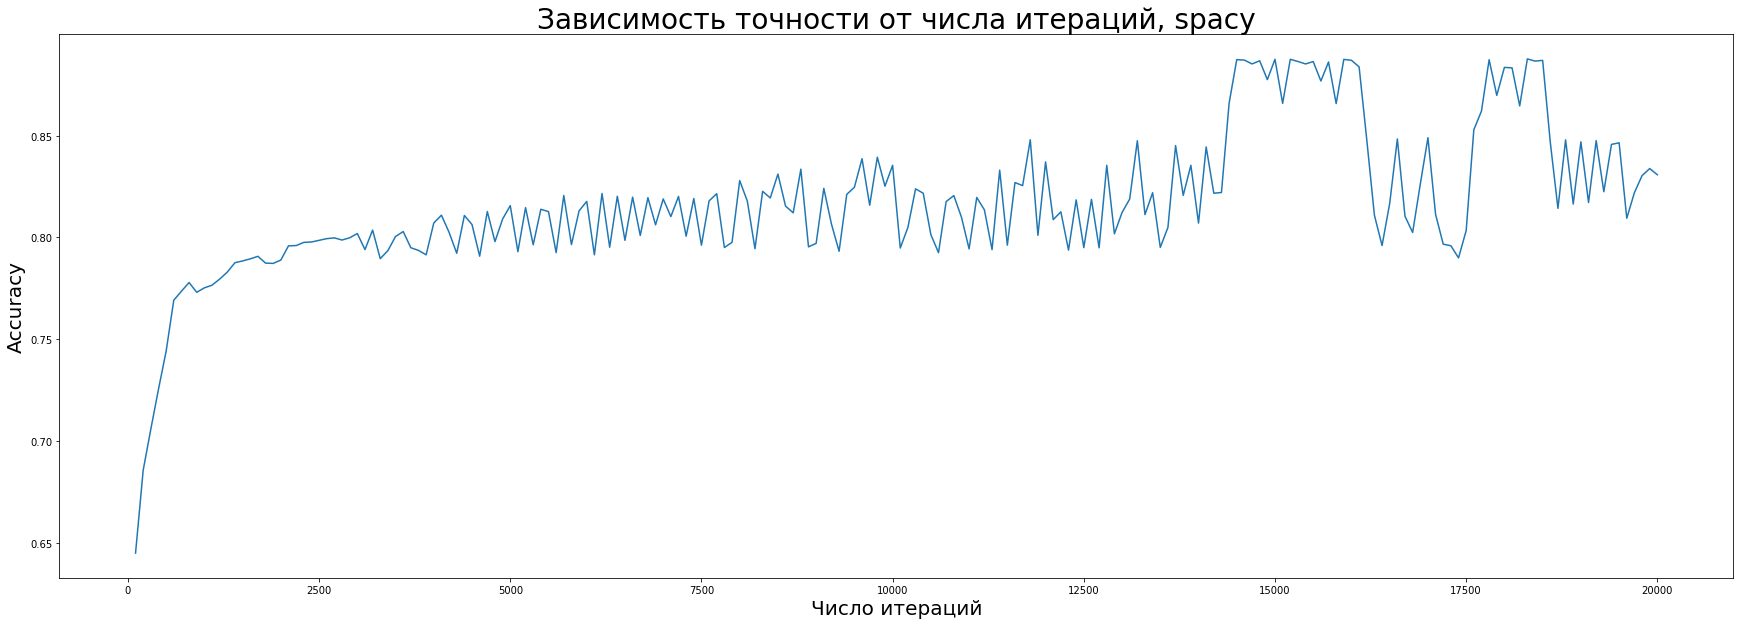

In [24]:
fig = plt.figure(figsize=[30, 10])

plt.plot(np.arange(1,201) * 100, accuracy)
plt.title("Зависимость точности от числа итераций, spacy", fontsize=28)
plt.xlabel("Число итераций", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.savefig("Images/spacy.png")

plt.show()



Попробуем другой алгоритм лемматизации: nltk

In [25]:
import nltk

In [26]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

In [27]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


In [28]:
texts_nltk = []

for item in train_texts:
    texts_nltk.append(" ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(item)]))

In [29]:
tests_nltk = []

for item in test_texts:
    tests_nltk.append(" ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(item)]))

In [30]:
train_nltk = add_1(vect.fit_transform(texts_nltk))
test_nltk = add_1(vect.transform(tests_nltk))

In [31]:
train_nltk.shape

(52061, 5972)

In [32]:
texts_nltk[0]

"explanation why the edits make under my username hardcore metallica fan be revert they be n't vandalism just closure on some gas after i vote at new york doll fac and please do n't remove the template from the talk page since i 'm retire now 89 205 38 27"

In [33]:
classifier = GDClassifier(step_alpha = 2.6, step_beta = 0, l2_coef = 0)

In [34]:
classifier.fit(train_nltk, train_target)

In [35]:
check_metrics(test_target, classifier.predict(test_nltk))

Accuracy:  0.813551944283227
Roc_Auc:  0.8554991859017622
Precision:  0.6241680532445923  - процент правильно токсичных
Recall:  0.9613967643761012  - процент выбранных токсичных


In [36]:
w_nltk = []
result_nltk = []

w = np.zeros(train_nltk.shape[1])

for i in range(200):
    classifier = GDClassifier(step_alpha = 3.4, step_beta = 0, max_iter = 100, l2_coef = 0)
    classifier.fit(train_nltk, train_target, w_0 = w)
    w_nltk.append(w)
    result_nltk.append(classifier.predict(test_nltk))
    w = classifier.get_weights()

In [37]:
train_nltk.shape

(52061, 5972)

In [38]:
acc_nltk = [accuracy_score(test_target, val) for val in result_nltk]

In [39]:
np.argmax(acc_nltk), acc_nltk[np.argmax(acc_nltk)]

(89, 0.8861965563938866)

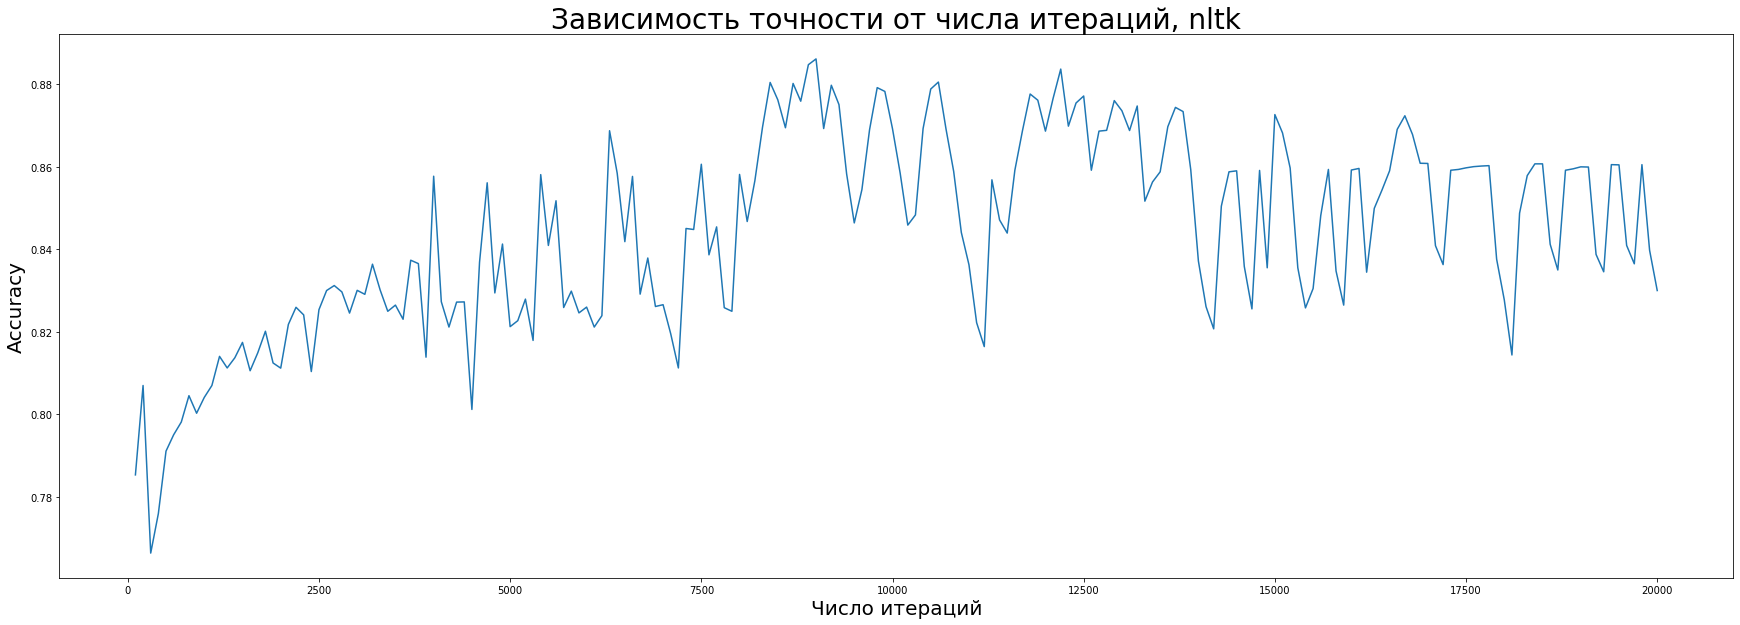

In [40]:
fig = plt.figure(figsize=[30, 10])

plt.plot(np.arange(1,201) * 100, acc_nltk)
plt.title("Зависимость точности от числа итераций, nltk", fontsize=28)
plt.xlabel("Число итераций", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.savefig("Images/nltk.png")

plt.show()

In [41]:
from textblob import TextBlob, Word, Sentence

In [42]:
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

# Lemmatize
sentence = "The striped bats are hanging on their feet for best"
lemmatize_with_postag(sentence)

'The striped bat be hang on their foot for best'

In [43]:
lemmatize_with_postag(train_texts[0])

"explanation why the edits make under my username hardcore metallica fan be revert they be n't vandalisms just closure on some gas after i vote at new york doll fac and please do n't remove the template from the talk page since i 'm retire now 89 205 38 27"

In [44]:
train_textblob = [lemmatize_with_postag(sentence) for sentence in train_texts]

In [45]:
test_textblob = [lemmatize_with_postag(sentence) for sentence in test_texts]

In [46]:
train_textblob[0]

"explanation why the edits make under my username hardcore metallica fan be revert they be n't vandalisms just closure on some gas after i vote at new york doll fac and please do n't remove the template from the talk page since i 'm retire now 89 205 38 27"

In [47]:
train_text = add_1(vect.fit_transform(train_textblob))
test_text = add_1(vect.transform(test_textblob))

In [48]:
from optimization import GDClassifier

In [49]:
classifier = GDClassifier(step_alpha = 2.6, step_beta = 0, l2_coef = 0)

In [50]:
classifier.fit(train_text, train_target)

In [51]:
check_metrics(test_target, classifier.predict(test_text))

Accuracy:  0.880586186883343
Roc_Auc:  0.8586126459556134
Precision:  0.801726894787336  - процент правильно токсичных
Recall:  0.8031395162582092  - процент выбранных токсичных


In [52]:
w_text = []
res_text = []

w = np.zeros(train_text.shape[1])

for i in range(200):
    classifier = GDClassifier(step_alpha = 3.4, step_beta = 0, max_iter = 100, l2_coef = 0)
    classifier.fit(train_text, train_target, w_0 = w)
    w_text.append(w)
    
    res_text.append(classifier.predict(test_text))
    w = classifier.get_weights()

In [53]:
train_text.shape

(52061, 5933)

In [54]:
acc_text = [accuracy_score(test_target, val) for val in res_text]

In [55]:
np.argmax(acc_text)

150

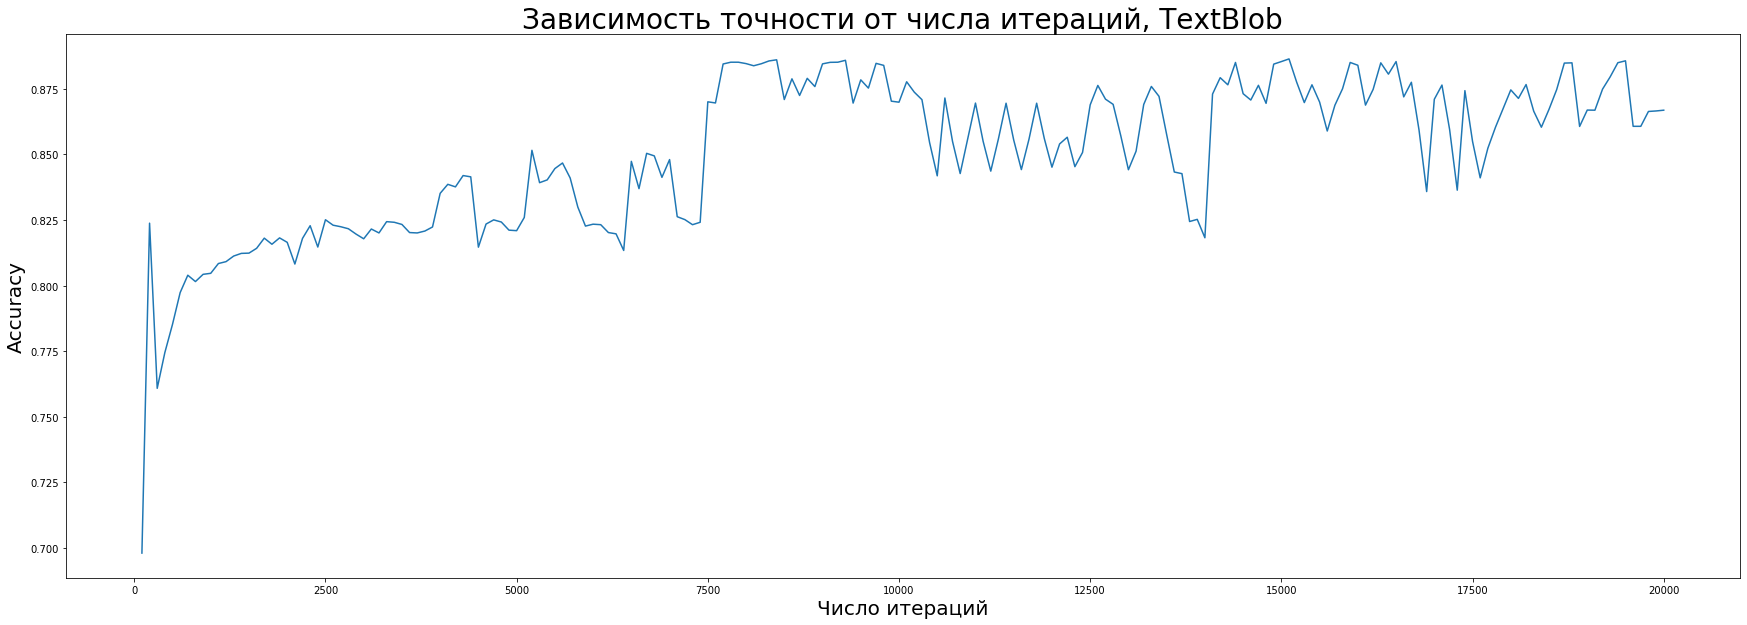

In [56]:
fig = plt.figure(figsize=[30, 10])

plt.plot(np.arange(1,201) * 100, acc_text)
plt.title("Зависимость точности от числа итераций, TextBlob",fontsize=28)
plt.xlabel("Число итераций", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.savefig("Images/TextBlob.png")

plt.show()

In [57]:
check_metrics(test_target, res_text[np.argmax(acc_text)])

Accuracy:  0.8863416521570904
Roc_Auc:  0.8775053751325992
Precision:  0.7868828297715549  - процент правильно токсичных
Recall:  0.8551978215601473  - процент выбранных токсичных


TreeTagger:

In [8]:
import treetaggerwrapper as ttpw
tagger = ttpw.TreeTagger(TAGLANG='en', TAGDIR='tagger')
tags = tagger.tag_text(train_texts[0])
lemmas = " ".join([t.split('\t')[-1] for t in tags])

/usr/local/lib/python3.7/site-packages/treetaggerwrapper.py:740: FutureWarning: Possible nested set at position 8
  re.IGNORECASE | re.VERBOSE)
/usr/local/lib/python3.7/site-packages/treetaggerwrapper.py:2044: FutureWarning: Possible nested set at position 152
  re.VERBOSE | re.IGNORECASE)
/usr/local/lib/python3.7/site-packages/treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
/usr/local/lib/python3.7/site-packages/treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)


In [9]:
train_tagger = [" ".join([t.split('\t')[-1] for t in tagger.tag_text(item)]) for item in train_texts]

In [10]:
test_tagger = [" ".join([t.split('\t')[-1] for t in tagger.tag_text(item)]) for item in test_texts]

In [11]:
train_tagger[0]

"explanation why the edit make under my username hardcore metallica fan be revert they be n't vandalism just closure on some gas after i vote at new york doll fac and please do n't remove the template from the talk page since i be retire now @card@ @card@ @card@ @card@"

In [71]:
train_treetagger = vect.fit_transform(train_tagger)
test_treetagger = vect.transform(test_tagger)

In [63]:
classifier = GDClassifier(step_alpha = 3.4, step_beta = 0, l2_coef = 0)

In [64]:
classifier.fit(train_treetagger, train_target)

In [65]:
check_metrics(test_target, classifier.predict(test_treetagger))

Accuracy:  0.8817469529889728
Roc_Auc:  0.8564445806407728
Precision:  0.811413578222368  - процент правильно токсичных
Recall:  0.7925676757968925  - процент выбранных токсичных


In [13]:
w_tagger = []
res_tagger = []

w = np.zeros(train_treetagger.shape[1])

for i in range(200):
    classifier = GDClassifier(step_alpha = 3.4, step_beta = 0, max_iter = 100, l2_coef = 0)
    classifier.fit(train_treetagger, train_target, w_0 = w)
    
    w_tagger.append(w)
    res_tagger.append(classifier.predict(test_treetagger))
    w = classifier.get_weights()

In [67]:
train_treetagger.shape

(52061, 5610)

In [68]:
acc_tagger = [accuracy_score(test_target, item) for item in res_tagger]

In [69]:
np.argmax(acc_tagger)

45

In [70]:
check_metrics(test_target, res_tagger[np.argmax(acc_tagger)])

Accuracy:  0.8912749081060166
Roc_Auc:  0.8759943416818063
Precision:  0.8091626683175979  - процент правильно токсичных
Recall:  0.8374179080570239  - процент выбранных токсичных


In [71]:
np.argwhere(w == 0)

array([], shape=(0, 1), dtype=int64)

In [73]:
holder = []
w_tagger = []
res_tagger = []



for i in range(60):
    classifier = GDClassifier(step_alpha = 3.4, step_beta = 0, max_iter = 100, l2_coef = 0)
    holder.append(classifier.fit(train_treetagger, train_target, w_0 = w, trace = True))
    
    w_tagger.append(w)
    res_tagger.append(classifier.predict(test_treetagger))
    w = classifier.get_weights()

In [78]:
w_list = [holder[i]['w'] for i in range(60)]

In [81]:
w_megalist = []
for i in range(60):
    w_megalist += w_list[i] 

In [84]:
res_megalist = [predict(test_treetagger, w) for w in w_megalist]

In [85]:
acc_megalist = [accuracy_score(test_target, res) for res in res_megalist]

In [86]:
max(acc_megalist)

0.8885664538595474

In [15]:
acc_tagger = [accuracy_score(test_target, item) for item in res_tagger]

In [16]:
check_metrics(test_target, res_tagger[np.argmax(acc_tagger)])

Accuracy:  0.8893886631843684
Roc_Auc:  0.8807331515392022
Precision:  0.79225768321513  - процент правильно токсичных
Recall:  0.8588819477815153  - процент выбранных токсичных


In [75]:
np.argmax(acc_tagger)

45

In [76]:
acc_tagger.__len__()

400

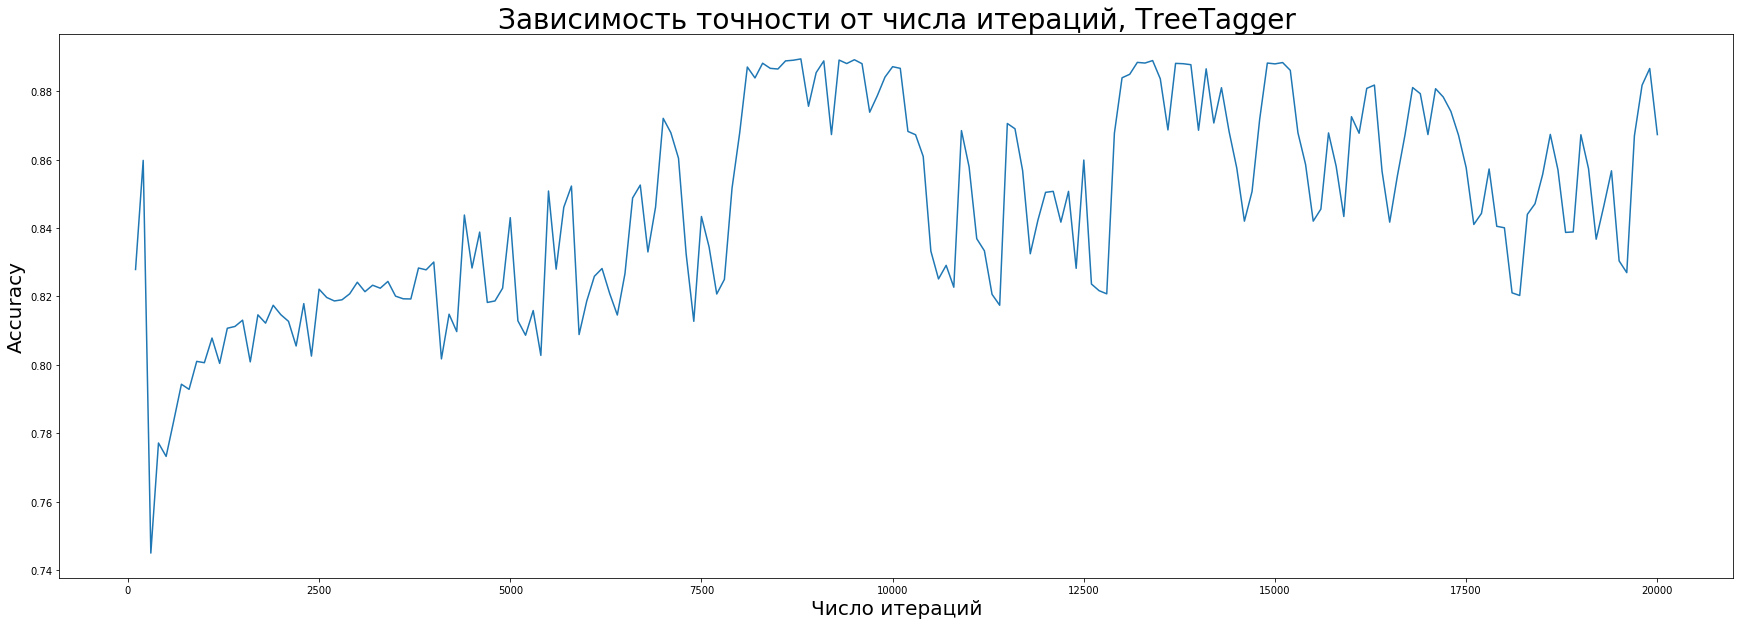

In [17]:
fig = plt.figure(figsize=[30, 10])

plt.plot(np.arange(1,201) * 100, acc_tagger)
plt.title("Зависимость точности от числа итераций, TreeTagger", fontsize=28)
plt.xlabel("Число итераций", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

#plt.savefig("Images/TreeTagger.png")

plt.show()

In [118]:
vect_last = CountVectorizer(min_df = 20)

In [119]:
train_treetagger = vect_last.fit_transform(train_tagger)

In [120]:
test_treetagger = vect_last.transform(test_tagger)

In [121]:
train_treetagger.shape

(52061, 5610)

In [63]:
from optimization import SGDClassifier

In [91]:
classifier = SGDClassifier(batch_size = 8000, step_alpha = 3.4, step_beta = 0, tolerance = 0, max_iter = 2000, l2_coef = 0)

In [92]:
holder_last = classifier.fit(train_treetagger, train_target, trace=True)

In [93]:
def predict(X, w):
    ans = np.sign(X * w)
    ans[ans == 0] = -1
    return ans

In [94]:
ws = holder_last['weights'][1:]

TypeError: list indices must be integers or slices, not str

In [ ]:
res = [predict(test_treetagger, w) for w in ws]

In [ ]:
acc = [accuracy_score(test_target, r) for r in res]

In [ ]:
epoch = holder['epoch_num'][1:]

In [ ]:
max(acc)

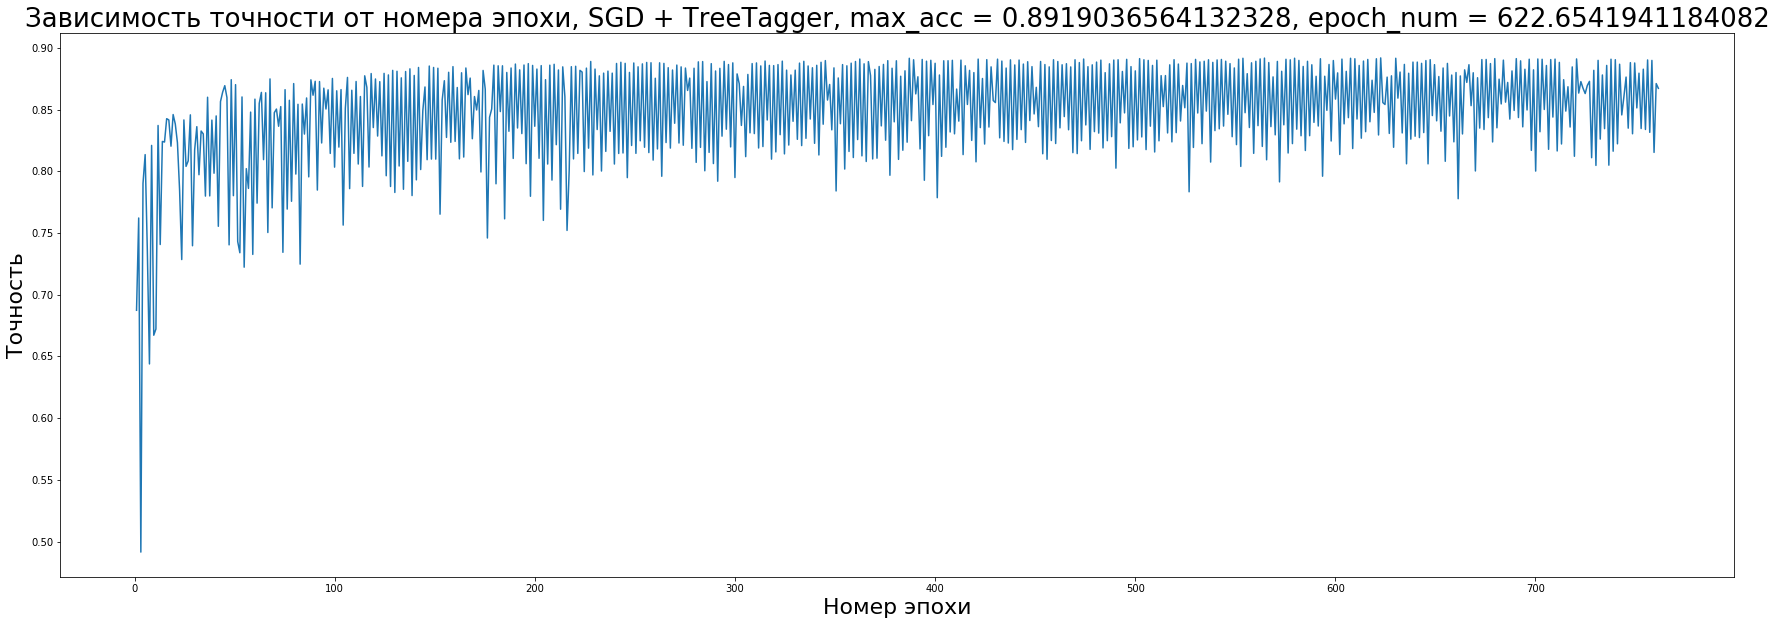

In [37]:
fig = plt.figure(figsize=[30, 10])

plt.plot(epoch, acc)
plt.title("Зависимость точности от номера эпохи, SGD + TreeTagger, max_acc = 0.8919036564132328, epoch_num = 622.6541941184082", fontsize=26)
plt.xlabel("Номер эпохи", fontsize=22)
plt.ylabel("Точность", fontsize=22)

#plt.savefig("Images/SGD+TreeTagger.png")

plt.show()

In [102]:
check_metrics(test_target, res[578])

Accuracy:  0.8919036564132328
Roc_Auc:  0.8819892164070984
Precision:  0.7994620442319187  - процент правильно токсичных
Recall:  0.8569597949703668  - процент выбранных токсичных


In [95]:
ws_last = holder_last['weights'][1:]

In [96]:
epoch_last = holder_last["epoch_num"][1:]

In [97]:
res_last = [predict(test_treetagger, w)  for w in ws_last]

In [98]:
acc_last = [accuracy_score(test_target, res) for res in res_last]

In [99]:
max(acc_last)

0.872847746179145

In [101]:
holder_last

{'epoch_num': [0,
  0.9219953516067692,
  1.997656595148,
  3.073317838689231,
  4.148979082230461,
  5.224640325771692,
  6.300301569312923,
  7.375962812854154,
  8.451624056395383,
  9.527285299936608,
  10.602946543477833,
  11.678607787019057,
  12.754269030560282,
  13.829930274101507,
  14.905591517642732,
  15.981252761183956,
  17.056914004725193,
  18.13257524826643,
  19.208236491807668,
  20.283897735348905,
  21.359558978890142,
  22.43522022243138,
  23.510881465972616,
  24.586542709513854,
  25.66220395305509,
  26.737865196596328,
  27.813526440137565,
  28.889187683678802,
  29.96484892722004,
  31.040510170761276,
  32.116171414302514,
  33.191832657843726,
  34.26749390138494,
  35.34315514492615,
  36.41881638846736,
  37.494477632008575,
  38.57013887554979,
  39.645800119091,
  40.72146136263221,
  41.797122606173424,
  42.87278384971464,
  43.94844509325585,
  45.02410633679706,
  46.09976758033827,
  47.175428823879486,
  48.2510900674207,
  49.32675131096191,


In [104]:
blessed_res = res[578]

In [106]:
def predict_proba(X, w):

        ans = X * w
        return 1 / (1 + np.exp(-1 * ans))

In [108]:
blessed_weight = ws[578]

In [122]:
roc_auc_score(test_target, predict_proba(test_treetagger, blessed_weight))

0.93626065655531

In [123]:
precision_score(test_target, predict_proba(test_treetagger, blessed_weight))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [117]:
test_treetagger.shape

(20676, 5335)

In [127]:
ind = [blessed_res[i] == test_target[i] for i in range(blessed_res.__len__())]

In [134]:
error_ind = np.argwhere(np.array(ind) == 0).T[0]

array([-1.,  1., -1., ..., -1., -1.,  1.])

In [141]:
blessed_probabilities = predict_proba(test_treetagger, blessed_weight)

In [147]:
blessed_probabilities

array([3.45326489e-03, 9.44850618e-01, 6.14909161e-04, ...,
       3.69203565e-01, 1.28233141e-08, 9.99999969e-01])

In [159]:
errors = (blessed_res - test_target) / 2

In [161]:
np.count_nonzero(errors)

2235

In [204]:
fn = np.where(errors > 0)[0]

In [190]:
words = np.array(test_data['comment_text'])

In [205]:
for ind in fn[0:10]:
    print(words[ind])
    print(ind)

:Dear god this site is horrible.
1
" 

 ==balance== 
 This page has one sentence about the basic definition of the word, and a huge amount about the slang/profane uses. Perhaps the former should be extended; is there no information about female dogs available beyond their name? This is an encyclopaedia, not a dictionary.  

  
 i feel that whoever is looking this definition up is very appropiate and should be deleted from wikipedia...IMMEDIATLY. this word is used very often and is also a very ""mean"" word. i belive that is majorly true. very much so. okay so, the good meaning is a female dog.  BITCH !!!!!!!!!It also stands for the name Brittany Fellows—Preceding unsigned comment added by   •    

 ==etymology== 
 The word bitch is from the Old Norse Bikkjuna meaning ""female of the dog"" of unknown origin, Grimm derives the Old Norse words from Lapp Pittja, But OED notes that ""the converse is equally possible."" 
 The adj. Bitchy was first seen in 1925.  
 The verb meaning to complai

In [ ]:
test_